In [1]:
#Install and Import Dependencies
#!pip install kaggle tensorflow matplotlib seaborn opencv-python

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

In [3]:
#Load Dataset from NPZ file
data = np.load("/content/ORL_faces.npz")
print(data.files)

['testY', 'testX', 'trainX', 'trainY']


In [4]:
data = np.load("/content/ORL_faces.npz")

X_train = data['trainX']
y_train = data['trainY']

X_test = data['testX']
y_test = data['testY']

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (240, 10304)
Test shape: (160, 10304)


In [5]:
#Create Validation Set from Training Data
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

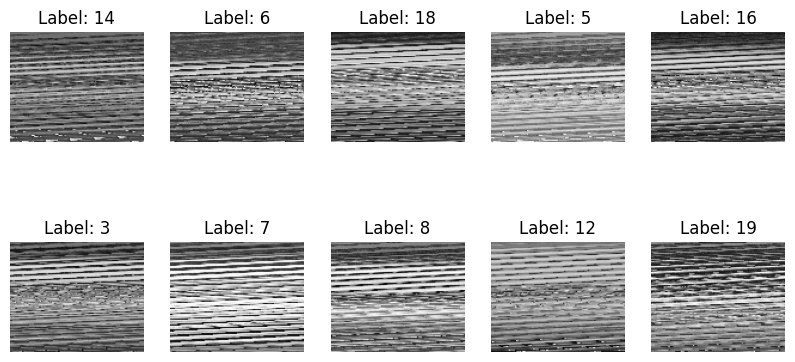

In [6]:
#Visualize Sample Images
plt.figure(figsize=(10,5))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_train[i].reshape(92, 112), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

plt.show()

In [7]:
#Preprocessing
IMG_SIZE = 128

def preprocess(images):
    processed = []
    for img in images:
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0
        processed.append(img)
    processed = np.array(processed)
    processed = np.expand_dims(processed, axis=-1)
    processed = np.repeat(processed, 3, axis=-1)
    return processed

X_train = preprocess(X_train)
X_val   = preprocess(X_val)
X_test  = preprocess(X_test)

y_train = to_categorical(y_train, num_classes=40)
y_val   = to_categorical(y_val, num_classes=40)
y_test  = to_categorical(y_test, num_classes=40)

In [8]:
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

y_train shape: (192, 40)
y_val shape: (48, 40)
y_test shape: (160, 40)


In [9]:
print("Unique labels:", np.unique(np.argmax(y_train, axis=1)))

Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [10]:
#Build CNN Model (Transfer Learning)
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(128,128,3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(40, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,596,200 (9.90 MB)

 Trainable params: 338,216 (1.29 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

X_train: (192, 128, 128, 3)
y_train: (192, 40)


In [12]:
#Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32
)

Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.0307 - loss: 4.6389 - val_accuracy: 0.0833 - val_loss: 3.4768
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0224 - loss: 4.0675 - val_accuracy: 0.1250 - val_loss: 3.1024
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.0743 - loss: 3.4556 - val_accuracy: 0.1875 - val_loss: 2.9300
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1205 - loss: 3.1653 - val_accuracy: 0.2708 - val_loss: 2.7932
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1819 - loss: 2.9217 - val_accuracy: 0.4167 - val_loss: 2.6643
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2472 - loss: 2.7990 - val_accuracy: 0.4792 - val_loss: 2.5540
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2016 - loss: 2.7447 - val_accuracy: 0.5208 - val_loss: 2.4594
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2554 - loss: 2.6907 - val_accuracy: 0.5417 - val_loss: 2.3770
E

In [13]:
#Print Classification Report
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.60      0.38      0.46         8
           1       0.73      1.00      0.84         8
           2       0.75      0.38      0.50         8
           3       0.57      1.00      0.73         8
           4       1.00      0.62      0.77         8
           5       0.54      0.88      0.67         8
           6       0.67      1.00      0.80         8
           7       0.71      0.62      0.67         8
           8       0.88      0.88      0.88         8
           9       0.67      1.00      0.80         8
          10       0.88      0.88      0.88         8
          11       0.45      0.62      0.53         8
          12       0.83      0.62      0.71         8
          13       0.44      0.50      0.47         8
          14       0.54      0.88      0.67         8
          15       1.00      0.12      0.22         8
          16      

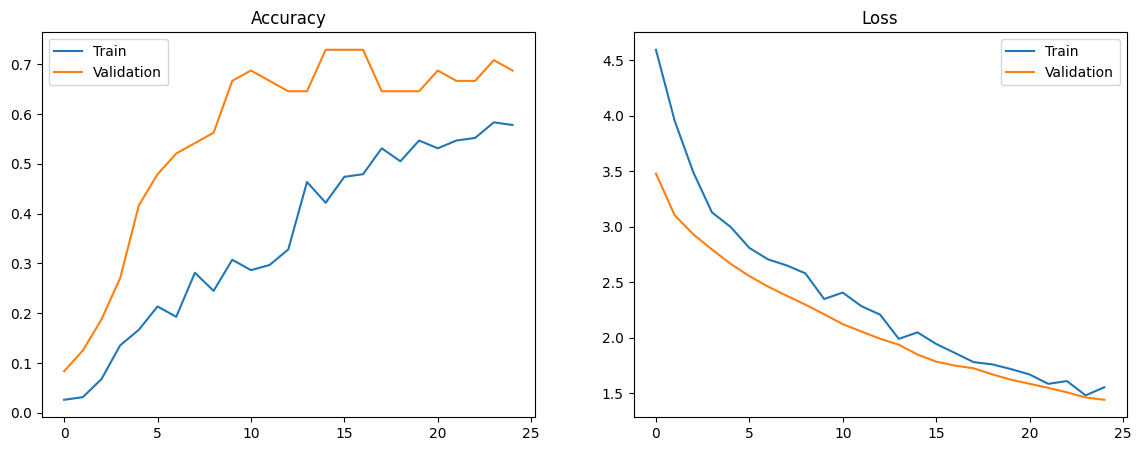

In [14]:
#Plot Training Curves
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.legend()

plt.show()